In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
## import modules
import bbmm.utils.preconditioner as precond
import bbmm.utils.conjugate_gradient as cg
import bbmm.functions.pivoted_cholesky as pc
import bbmm.functions.pivoted_cholesky_ref as pc_ref # to use this script we need "torch", please comment out if not needed.
import bbmm.utils.calc_logdet as calc_logdet
import bbmm.utils.calc_trace as calc_trace
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(pc_ref)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
reload()

In [5]:
import gpytorch
import torch
import linear_operator
from linear_operator.operators import (
    AddedDiagLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    DenseLinearOperator,
)

In [6]:
def generate_K(N, seed=0, noise=1e-06):
    """
    generate positive definite symmetric matrix
    """
    K = jax.random.normal(jax.random.PRNGKey(seed), (N, N))
    # K = K @ K.T + 30* jnp.eye(N) + noise*jnp.eye(N)
    # K = jnp.dot(K, K.T) + noise*jnp.eye(N)
    # K = jnp.dot(K, K.T) / N
    K = jnp.dot(K, K.T)/N
    # K += (noise+30)*jnp.eye(N) ## ??
    K += (2)*jnp.eye(N)
    K += (noise)*jnp.eye(N)
    if not is_positive_definite(K):
        raise Exception("K is not positive definite !")
    return K

In [7]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [8]:
def rel_error(true, pred):
    nonzero_index = jnp.where(true != 0.)
    true = true[nonzero_index]
    pred = pred[nonzero_index]
    return jnp.mean(jnp.abs((true-pred)/true))

## 5. modified preconditioned conjugate gradient

### N=200

In [257]:
N = 200
rank=15
noise = 1e-06
n_tridiag = 10
K = generate_K(N)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,1))
zs = jax.random.normal(jax.random.PRNGKey(1), (N, n_tridiag))
K_torch = torch.from_numpy(np.array(K))
rhs = jnp.concatenate([zs, y], axis=1)
rhs_torch = torch.from_numpy(np.array(rhs))

In [258]:
Kinvy_linalg = jnp.linalg.solve(K, rhs)

In [259]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)

In [260]:
Kinvy, j,t_mat = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=True, tolerance=0.01, n_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy))

j=0 r1norm: 0.3284193625623561
j=1 r1norm: 0.0924476128233194
j=2 r1norm: 0.0246060473082805
j=3 r1norm: 0.006555798544265459
j=4 r1norm: 0.0017374285902254018
j=5 r1norm: 0.0004555282069522226
j=6 r1norm: 0.00011784840630136103
j=7 r1norm: 3.0876183130328414e-05
j=8 r1norm: 8.037598219340866e-06
j=9 r1norm: 2.161714209467397e-06
j=10 r1norm: 2.161714209467397e-06
j=11 r1norm: 2.161714209467397e-06
j=12 r1norm: 2.161714209467397e-06
j=13 r1norm: 2.161714209467397e-06
j=14 r1norm: 2.161714209467397e-06
j=15 r1norm: 2.161714209467397e-06
j=16 r1norm: 2.161714209467397e-06
j=17 r1norm: 2.161714209467397e-06
j=18 r1norm: 2.161714209467397e-06
j=19 r1norm: 2.161714209467397e-06
j=20 r1norm: 2.161714209467397e-06
converged
1.1905963895496283e-05


In [261]:
j

20

In [262]:
def calc_logdet_linalg(K):
    L = jnp.linalg.cholesky(K)
    return jnp.sum(jnp.log(jnp.diag(L))) * 2

In [292]:
def check_logdet(n_tridiag=10, rank=15, tol=0.01):
    logdet_list = []
    for i in range(10):
        y = jax.random.normal(key=jax.random.PRNGKey(i), shape=(N,1))
        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
        if precondition:
            zs = jax.random.multivariate_normal(
            jax.random.PRNGKey(0),
            jnp.zeros(len(y)),
            precond_lt,
            shape=(n_tridiag,),
            ).T
        else:
            zs = jax.random.normal(jax.random.PRNGKey(i+1), (N, n_tridiag))
        rhs = jnp.concatenate([zs, y], axis=1)
        
        Kinvy, j,t_mat = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=False, tolerance=tol, n_tridiag=n_tridiag)
        logdet_list.append(calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache))
        logdet_linalg = calc_logdet_linalg(K)
    logdet = np.mean(logdet_list)
    relative_error = np.mean(np.abs((logdet_linalg-np.array(logdet_list))/logdet_linalg))
    return logdet, float(logdet_linalg), relative_error

In [264]:
check_logdet(2)

(208.58854365722354, 209.65905623055232, 0.01522419436025788)

In [265]:
check_logdet(5)

(208.18343449977365, 209.65905623055232, 0.010771360541280594)

In [266]:
check_logdet()

(209.2419802557477, 209.65905623055232, 0.005045458284575958)

In [267]:
check_logdet(15)

(209.890818163449, 209.65905623055232, 0.007117597530732431)

In [268]:
check_logdet(20)

(209.99468300154587, 209.65905623055232, 0.004790205889365764)

In [269]:
calc_logdet.calc_logdet(K.shape, t_mat, precondition)

DeviceArray(211.37720482, dtype=float64)

In [270]:
logdet_linalg = calc_logdet_linalg(K)
logdet_linalg

DeviceArray(209.65905623, dtype=float64)

In [271]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N, dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [272]:
preconditioner_torch, _, precond_logdet_torch = added_diag._preconditioner()
Kinvy_torch, t_mat_torch = added_diag._solve(rhs_torch, preconditioner=preconditioner_torch, num_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))

1.2000054205869013e-05


In [273]:
added_diag._preconditioner()

(None, None, None)

In [274]:
added_diag.inv_quad_log_det(inv_quad_rhs=rhs_torch[:, -1:], logdet=True)

(tensor(75.7214, dtype=torch.float64), tensor(209.6591, dtype=torch.float64))

In [275]:
linear_operator.settings.min_preconditioning_size.value()
# linear_operator.settings.deterministic_probes.on()
# linear_operator.settings.max_lanczos_quadrature_iterations.value()
# linear_operator.settings.fast_computations.log_prob.off()
# linear_operator.settings.skip_logdet_forward.off()
linear_operator.settings.max_preconditioner_size.value()

15

In [276]:
linear_operator.settings.cholesky_max_tries.value()

3

In [277]:
eval_torch, evec_torch = linear_operator.utils.lanczos.lanczos_tridiag_to_diag(t_mat_torch)
slq = linear_operator.utils.stochastic_lq.StochasticLQ()
(logdet_term,) = slq.to_dense(added_diag.matrix_shape, eval_torch, evec_torch,  [lambda x: x.log()])

In [278]:
logdet_term

tensor(211.3773, dtype=torch.float64)

In [279]:
dKdtheta = jax.random.normal(jax.random.PRNGKey(1), (N, N))+5*jnp.eye(N)

### N=3000

In [280]:
N = 3000
rank=15
noise = 1e-06
n_tridiag = 10
K = generate_K(N)
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,1))
if precondition:
    zs = jax.random.multivariate_normal(
            jax.random.PRNGKey(0),
            jnp.zeros(len(y)),
            precond_lt,
            shape=(n_tridiag,),
    ).T
else:
    zs = jax.random.normal(jax.random.PRNGKey(0), (N, n_tridiag))
K_torch = torch.from_numpy(np.array(K))
rhs = jnp.concatenate([zs, y], axis=1)
rhs_torch = torch.from_numpy(np.array(rhs))

In [281]:
Kinvy_linalg = jnp.linalg.solve(K, rhs)

In [282]:
Kinvy, j, t_mat = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=True, tolerance=1e-06, n_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy))

j=0 r1norm: 0.9403330791856419
j=1 r1norm: 0.919494556244436
j=2 r1norm: 0.9157604492750547
j=3 r1norm: 0.9154192961151623
j=4 r1norm: 0.9153735362651542
j=5 r1norm: 0.9151100471291478
j=6 r1norm: 0.911708800870609
j=7 r1norm: 0.8668497902548907
j=8 r1norm: 0.565180398825676
j=9 r1norm: 0.19353626522118292
j=10 r1norm: 0.05681112765774381
j=11 r1norm: 0.01976136473738658
j=12 r1norm: 0.009889035115684308
j=13 r1norm: 0.006687355561375818
j=14 r1norm: 0.0033222329632622864
j=15 r1norm: 0.0010107468681291069
j=16 r1norm: 0.00026641847547480475
j=17 r1norm: 7.086498595331619e-05
j=18 r1norm: 1.8878217010346526e-05
j=19 r1norm: 4.9932375068925705e-06
j=20 r1norm: 1.3385216743686214e-06
j=21 r1norm: 3.654617130103114e-07
converged
3.850894070091502e-05


In [283]:
check_logdet(2, tol=1e-02)

(3136.037302952893, 3147.3212181150857, 0.003585244206166785)

In [284]:
check_logdet(10, rank=5, tol=1e-02)

(3104.471791627737, 3147.3212181150857, 0.013614570460974798)

In [285]:
check_logdet(n_tridiag=10, rank=10, tol=1e-02)

(3109.990586800028, 3147.3212181150857, 0.011861080813802344)

In [286]:
check_logdet(n_tridiag=10, rank=20, tol=1e-02)

(3118.8671552069427, 3147.3212181150857, 0.009040724138473536)

In [287]:
check_logdet(n_tridiag=10, rank=40, tol=1e-02)

(3094.734755644815, 3147.3212181150857, 0.016708323944692426)

In [233]:
check_logdet(n_tridiag=10, rank=15, tol=1e-02)

(3133.2928887234157, 3147.3212181150857, 0.0044572283600818816)

In [296]:
n_tridiag_list = [2, 5, 10, 20, 40]
logdet_list = []
rel_error_list = []
for n_tridiag in n_tridiag_list:
    logdet, logdet_linalg, rel_err = check_logdet(n_tridiag=n_tridiag)
    logdet_list.append(logdet)
    rel_error_list.append(rel_err)

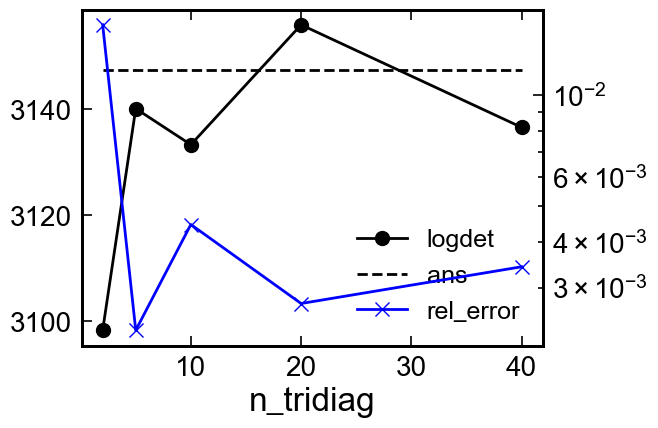

In [297]:
fig, ax = plt.subplots()
ax.plot(n_tridiag_list, logdet_list, marker='o', label='logdet')
ax.hlines(logdet_linalg, n_tridiag_list[0], n_tridiag_list[-1], linestyle='--', label='ans')
ax.set_xlabel('n_tridiag')
ax2 = ax.twinx()
ax2.semilogy(n_tridiag_list, rel_error_list, color='b', marker='x', label='rel_error')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Create a legend for the first line in each axes
ax.legend(lines + lines2, labels + labels2, loc='best')

In [298]:
rank_list = [0, 2, 5, 10, 20, 40, 80]
logdet_list = []
rel_error_list = []
for rank in rank_list:
    logdet, logdet_linalg, rel_err = check_logdet(n_tridiag=10, rank=rank)
    logdet_list.append(logdet)
    rel_error_list.append(rel_err)

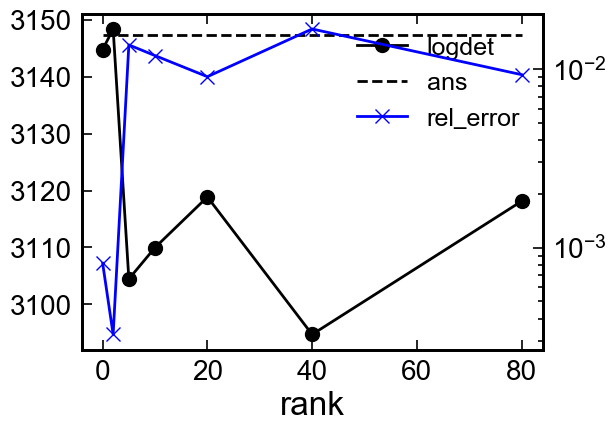

In [299]:
fig, ax = plt.subplots()
ax.plot(rank_list, logdet_list, marker='o', label='logdet')
ax.hlines(logdet_linalg, rank_list[0], rank_list[-1], linestyle='--', label='ans')
ax.set_xlabel('rank')
ax2 = ax.twinx()
ax2.semilogy(rank_list, rel_error_list, color='b', marker='x', label='rel_error')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Create a legend for the first line in each axes
ax.legend(lines + lines2, labels + labels2, loc='best')

In [209]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N, dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [210]:
preconditioner_torch, precond_lt_torch, precond_logdet_torch = added_diag._preconditioner()
Kinvy_torch, t_mat_torch = added_diag._solve(rhs_torch, preconditioner=preconditioner_torch, num_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))
linear_operator.settings.cg_tolerance._set_value(1)

9.56730751780832e-05


In [211]:
precond_args = precond_lt_torch.representation()

In [212]:
covar_root = precond_lt_torch.root_decomposition().root

In [213]:
base_samples = torch.randn(
                        *precond_lt_torch.batch_shape,
                        covar_root.size(-1),
                        n_tridiag,
                        dtype=precond_lt_torch.dtype,
                        device=precond_lt_torch.device,
)

In [214]:
probe_vectors = covar_root.matmul(base_samples).permute(-1, *range(precond_lt_torch.dim() - 1))

In [215]:
range(precond_lt_torch.dim() - 1)

range(0, 1)

In [216]:
precond_logdet_torch, precond_logdet_cache

(tensor(-41220.8623, dtype=torch.float64),
 DeviceArray(-41220.86229076, dtype=float64))

In [217]:
probe_vectors = precond_lt_torch.zero_mean_mvn_samples(15)
# probe_vectors

In [218]:
logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)
logdet, precond_logdet_cache

(DeviceArray(3155.87454666, dtype=float64),
 DeviceArray(-41220.86229076, dtype=float64))

In [219]:
added_diag.inv_quad_log_det(inv_quad_rhs=rhs_torch[:, -1:], logdet=True)

(tensor(1133.0245, dtype=torch.float64),
 tensor(3211.7748, dtype=torch.float64))

In [220]:
eval_torch, evec_torch = linear_operator.utils.lanczos.lanczos_tridiag_to_diag(t_mat_torch)
slq = linear_operator.utils.stochastic_lq.StochasticLQ()
(logdet_term,) = slq.to_dense(added_diag.matrix_shape, eval_torch, evec_torch,  [lambda x: x.log()])

In [221]:
logdet_term + precond_logdet_torch

tensor(3155.8756, dtype=torch.float64)

In [222]:
precond_logdet_torch

tensor(-41220.8623, dtype=torch.float64)

In [223]:
precond_logdet_cache

DeviceArray(-41220.86229076, dtype=float64)

In [224]:
logdet_linalg = calc_logdet_linalg(K)
logdet_linalg

DeviceArray(3147.32121812, dtype=float64)

### N=7000

In [159]:
N = 7000
rank=15
noise = 1e-06
n_tridiag = 10
K = generate_K(N)
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,1))
if precondition:
    zs = jax.random.multivariate_normal(
            jax.random.PRNGKey(0),
            jnp.zeros(len(y)),
            precond_lt,
            shape=(n_tridiag,),
    ).T
else:
    zs = jax.random.normal(jax.random.PRNGKey(0), (N, n_tridiag))
K_torch = torch.from_numpy(np.array(K))
rhs = jnp.concatenate([zs, y], axis=1)
rhs_torch = torch.from_numpy(np.array(rhs))

In [160]:
Kinvy_linalg = jnp.linalg.solve(K, rhs)

In [162]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
Kinvy, j, t_mat= cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=True, tolerance=0.01, n_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy))

j=0 r1norm: 0.9391067610671915
j=1 r1norm: 0.917918143723665
j=2 r1norm: 0.9130531920376856
j=3 r1norm: 0.9124254315125387
j=4 r1norm: 0.9123661416989475
j=5 r1norm: 0.9122615106381415
j=6 r1norm: 0.9107938321567703
j=7 r1norm: 0.8903422641099534
j=8 r1norm: 0.7020234332253318
j=9 r1norm: 0.28727865663878643
j=10 r1norm: 0.08312585152070112
j=11 r1norm: 0.02475743763235144
j=12 r1norm: 0.009046651164862097
j=13 r1norm: 0.004788316773479587
j=14 r1norm: 0.0028720092347572653
j=15 r1norm: 0.001036345510922713
j=16 r1norm: 0.00028167873500318537
j=17 r1norm: 7.580046858754703e-05
j=18 r1norm: 1.9946898483479506e-05
j=19 r1norm: 5.344976378002605e-06
j=20 r1norm: 1.4376086554975945e-06
converged
0.0001174276183541353


In [163]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N, dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [164]:
preconditioner_torch, _, precond_logdet_torch = added_diag._preconditioner()
Kinvy_torch, t_mat_torch = added_diag._solve(rhs_torch, preconditioner=preconditioner_torch, num_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))
linear_operator.settings.cg_tolerance._set_value(1)

0.00013994710861929468


In [166]:
logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)
logdet, precond_logdet_cache

(DeviceArray(7322.34028093, dtype=float64),
 DeviceArray(-96482.98874765, dtype=float64))

In [167]:
added_diag.inv_quad_log_det(inv_quad_rhs=rhs_torch[:, -1:], logdet=True)

(tensor(2554.9792, dtype=torch.float64),
 tensor(7334.4098, dtype=torch.float64))

In [168]:
eval_torch, evec_torch = linear_operator.utils.lanczos.lanczos_tridiag_to_diag(t_mat_torch)
slq = linear_operator.utils.stochastic_lq.StochasticLQ()
(logdet_term,) = slq.to_dense(added_diag.matrix_shape, eval_torch, evec_torch,  [lambda x: x.log()])

In [169]:
logdet_term + precond_logdet_torch

tensor(7322.3428, dtype=torch.float64)

In [170]:
logdet_linalg = calc_logdet_linalg(K)
logdet_linalg

DeviceArray(7343.7469261, dtype=float64)